# Plot perturbation anomalies.

In [1]:
# datasets/analysis
import numpy as np
import xarray as xr

# cosima
import cosima_cookbook as cc

# plotting
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D
import cmocean.cm as cmo

In [2]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 251.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38065,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 251.19 GiB
Comm: tcp://127.0.0.1:45411,Total threads: 4
Dashboard: /proxy/39237/status,Memory: 35.88 GiB
Nanny: tcp://127.0.0.1:42143,


In [3]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

# database for perturbations
session_dir = '/g/data/e14/hd4873/access-om2-01/project03_misc_data/databases/SSP2100_experiments_nodaily.db'
expt_session = cc.database.create_session(session_dir)
ssp585 = '01deg_jra55v13_ryf9091_ssp585'
ssp585mw = '01deg_jra55v13_ryf9091_ssp585_mw'
ssp245 = '01deg_jra55v13_ryf9091_ssp245'
ssp245mw = '01deg_jra55v13_ryf9091_ssp245_mw'

Define directories

In [4]:
ctrl_dir = '/g/data/e14/hd4873/access-om2-01/project03_cmip6_forcing/JRA55-do_input_files/V1-3/'
ssp245_dir = '/g/data/e14/hd4873/access-om2-01/project03_cmip6_forcing/JRA55-do_input_files/ssp245/'
ssp585_dir = '/g/data/e14/hd4873/access-om2-01/project03_cmip6_forcing/JRA55-do_input_files/ssp585/'
ssp245mw_dir = '/g/data/e14/hd4873/access-om2-01/project03_cmip6_forcing/JRA55-do_input_files/ssp245_mw/'
ssp585mw_dir = '/g/data/e14/hd4873/access-om2-01/project03_cmip6_forcing/JRA55-do_input_files/ssp585_mw/'

In [5]:
# topography data for plotting:
ht = cc.querying.getvar(control, 'ht' , master_session, n=1)
land_mask = np.squeeze(ht.values) * 0
land_mask[np.isnan(land_mask)] = 1
land_mask_masked = np.ma.masked_where((land_mask == 0), land_mask)

# modify southern most latitude (for plotting)
land_mask_lat = ht.yt_ocean.values
land_mask_lat[0] = -90
lons = ht.xt_ocean.values

def colorbar_horz(cb, axes, label):
    fs = 16
    cbaxes = fig.add_axes(axes)
    cbar = plt.colorbar(cb, cax = cbaxes, orientation = 'horizontal',extend = 'both')
    cbar.set_label(label,fontsize=fs,labelpad=6)
    cbar.ax.tick_params(labelsize=fs, labeltop=True)
    return cbar

Plot figure

In [6]:
vars_file = ['t_10','rlds', 'u_10','v_10','rain','snow']

vars_name = ['tas_10m','rlds', 'uas_10m','vas_10m','prrn','prsn']

vars_long_name = ['Surface air temperature anomaly',
                  'Surface downwelling longwave radiation anomaly', 
                  'Zonal surface wind anomaly',
                  'Meridional surface wind anomaly',
                  'Rainfall anomaly',
                  'Snowfall anomaly']

expts_labels = ['SSP245','SSP585']

labels = ['A','B','C','D','E','F','G','H','I','J','K','L']

model_names = ['ACCESS-CM2','ACCESS-ESM1-5','AWI-CM-1-1-MR',
               'BCC-CSM2-MR','CAS-ESM2-0','CMCC-CM2-SR5',
               'CMCC-ESM2','CanESM5','EC-Earth3',
               'EC-Earth3-CC','EC-Earth3-Veg','EC-Earth3-Veg-LR',
               'FGOALS-f3-L','GFDL-CM4','GFDL-ESM4',
               'IITM-ESM','INM-CM4-8','INM-CM5-0',
               'MIROC6',
               'MPI-ESM1-2-HR','MPI-ESM1-2-LR','MRI-ESM2-0']


dict_vars = {'t_10': {'file_name': 'RYF.t_10.1990_1991.nc', 
                      'ds_name': 'tas_10m', 
                      'levels_anom': np.arange(0, 6.25,0.25),
                      'cmap': cmo.amp,
                      'multiplier': 1,
                      'constant': -273.15, 
                      'cbar_label': '\u00b0C'},
             'rlds': {'file_name': 'RYF.rlds.1990_1991.nc', 
                      'ds_name': 'rlds', 
                      'levels_anom': np.arange(0, 31, 1),
                      'cmap': cmo.amp,
                      'multiplier': 1,
                      'constant': 0, 
                      'cbar_label': 'W m$^{-2}$'},
             'u_10': {'file_name': 'RYF.u_10.1990_1991.nc', 
                      'ds_name': 'uas_10m', 
                      'levels_anom': np.arange(-1.6, 1.7, 0.1),
                      'cmap': cmo.balance,
                      'multiplier': 1,
                      'constant': 0, 
                      'cbar_label': 'm s$^{-1}$'}, 
             'v_10': {'file_name': 'RYF.v_10.1990_1991.nc', 
                      'ds_name': 'vas_10m', 
                      'levels_anom': np.arange(-1.0, 1.1, 0.1),
                      'cmap': cmo.balance,
                      'multiplier': 1, 
                      'constant': 0, 
                      'cbar_label': 'm s$^{-1}$'},
             'rain': {'file_name': 'RYF.rain.1990_1991.nc', 
                      'ds_name': 'prrn', 
                      'levels_anom': np.arange(-0.16, 0.17, 0.01),
                      'cmap': cmo.balance,
                      'multiplier': 1e4, 
                      'constant': 0, 
                      'cbar_label': 'x 10$^{-4}$ kg m$^{-2}$ s$^{-1}$'},
             'snow': {'file_name': 'RYF.snow.1990_1991.nc', 
                      'ds_name': 'prsn', 
                      'levels_anom': np.arange(-1, 1.05, 0.05),
                      'cmap': cmo.balance,
                      'multiplier': 1e5, 
                      'constant': 0, 
                      'cbar_label': 'x 10$^{-5}$ kg m$^{-2}$ s$^{-1}$'},
            }
             
# load in wind divider line
div_line = xr.open_dataset('/home/561/jn8053/g_e14/2022-GRL-easterlies/data/smooth_div_line.nc')['__xarray_dataarray_variable__']
div_line = div_line.rename('wind_div')
x = div_line[0].values
y = div_line[1].values
x[x<0] = x[x<0] + 360

In [ ]:
%%time

plt.rcParams.update({'font.size': 14})

# Global
fig, axes = plt.subplots(6, 2, figsize=(16,20), sharex=True, sharey=True, width_ratios=[0.93,1.0])
plt.subplots_adjust(wspace=0.04, hspace=0.18)

# Add subplot label, 1000m contour, model land masses
for i, ax in enumerate(axes.flatten()):
    ax.text(0.02, 0.85, f'{labels[i]}',  c='k', fontsize=25, fontweight='bold', transform=ax.transAxes)
    ax.contourf(lons,land_mask_lat,land_mask_masked,colors='dimgrey',levels=[0,1], alpha=1,zorder=2,)

for i, ax in enumerate(axes[:,0].flatten()):
    print(dict_vars[f'{vars_file[i]}']['ds_name'])
    ax.text(0.02, 0.07, f'{expts_labels[0]}', fontsize=14, fontweight='bold', color='k', ha='left', transform=ax.transAxes,
                bbox=dict(facecolor='w', alpha=0.8, edgecolor='dimgrey', boxstyle='round,pad=0.2'))
    ax.set_yticks(np.arange(-80, -30, 10))
    ax.set_yticklabels(['80\u00b0S', '70\u00b0S', '60\u00b0S', '50\u00b0S', '40\u00b0S'])

    # open data using dictionary
    constant = dict_vars[f'{vars_file[i]}']['constant']
    multiplier = dict_vars[f'{vars_file[i]}']['multiplier']
    var_name = dict_vars[f'{vars_file[i]}']['ds_name']
    cmap = dict_vars[f'{vars_file[i]}']['cmap']
    if i < 2:
        extend='max'
    else:
        extend='both'
    ctrl = (xr.open_dataset(ctrl_dir + dict_vars[f'{vars_file[i]}']['file_name']).load() + constant) * multiplier
    ssp245 = (xr.open_dataset(ssp245_dir + dict_vars[f'{vars_file[i]}']['file_name']).load() + constant) * multiplier

    # reorder and concatenate data so that longitude matches later figures in paper
    # first define new longitudes
    new_lon = np.concatenate((ctrl.longitude[143:].values, ctrl.longitude[:143].values))
    new_lon[new_lon > 80] = new_lon[new_lon > 80] - 360
    ctrl = xr.concat((ctrl[var_name][:,:,143:], ctrl[var_name][:,:,0:143]), dim='longitude')
    ssp245 = xr.concat((ssp245[var_name][:,:,143:], ssp245[var_name][:,:,0:143]), dim='longitude')
    # replace longitude coordinate values with modified longitude values
    ctrl['longitude'] = new_lon
    ssp245['longitude'] = new_lon
    
    # plot data
    ax.contourf(ctrl.longitude, ctrl.latitude, ssp245.mean('time') - ctrl.mean('time'), 
                          cmap=cmap, levels=dict_vars[f'{vars_file[i]}']['levels_anom'], extend=extend)
    ax.set_title(f'{vars_long_name[i]}', loc='left', fontweight='bold')

    
for i, ax in enumerate(axes[:,1].flatten()):
    print(dict_vars[f'{vars_file[i]}']['ds_name'])
    ax.text(0.02, 0.07, f'{expts_labels[1]}', fontsize=14, fontweight='bold', color='k', ha='left', transform=ax.transAxes,
                bbox=dict(facecolor='w', alpha=0.8, edgecolor='dimgrey', boxstyle='round,pad=0.2'))
    
    # open data using dictionary
    constant = dict_vars[f'{vars_file[i]}']['constant']
    multiplier = dict_vars[f'{vars_file[i]}']['multiplier']
    var_name = dict_vars[f'{vars_file[i]}']['ds_name']
    cmap = dict_vars[f'{vars_file[i]}']['cmap']
    if i < 2:
        extend='max'
    else:
        extend='both'
    ctrl = (xr.open_dataset(ctrl_dir + dict_vars[f'{vars_file[i]}']['file_name']).load() + constant) * multiplier
    ssp585 = (xr.open_dataset(ssp585_dir + dict_vars[f'{vars_file[i]}']['file_name']).load() + constant) * multiplier

    # now concatenate variables so they match model output (-280 to 80)
    # first define new longitudes
    new_lon = np.concatenate((ctrl.longitude[143:].values, ctrl.longitude[:143].values))
    new_lon[new_lon > 80] = new_lon[new_lon > 80] - 360
    ctrl = xr.concat((ctrl[var_name][:,:,143:], ctrl[var_name][:,:,0:143]), dim='longitude')
    ssp585 = xr.concat((ssp585[var_name][:,:,143:], ssp585[var_name][:,:,0:143]), dim='longitude')
    # replace longitude coordinate values with modified longitude values
    ctrl['longitude'] = new_lon
    ssp585['longitude'] = new_lon
    
    # plot data
    cb_anom = ax.contourf(ctrl.longitude, ctrl.latitude, ssp585.mean('time') - ctrl.mean('time'), 
                          cmap=cmap, levels=dict_vars[f'{vars_file[i]}']['levels_anom'], extend=extend)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='4%', pad=0.15)
    fig.colorbar(cb_anom, cax=cax, orientation='vertical',label=dict_vars[f'{vars_file[i]}']['cbar_label'], extend=extend)

for i, ax in enumerate(axes.flatten()[4:8]): 
    ax.plot(x[:1044]-360, y[:1044], 'navy', linewidth=1, ls='--', zorder=2)
    ax.plot(x[1044:1444], y[1044:1444], 'navy', linewidth=1, ls='--', zorder=2)
    ax.plot(x[1444:]-360, y[1444:], 'navy', linewidth=1, ls='--', zorder=2)

axes[0,0].set_ylim([-80,-40])
axes[0,0].set_xlim([-280,80])
axes[5,0].set_xticklabels(['','110\u00b0E','160\u00b0E','150\u00b0W','100\u00b0W','50\u00b0W','0\u00b0','50\u00b0E'])
axes[5,1].set_xticklabels(['','110\u00b0E','160\u00b0E','150\u00b0W','100\u00b0W','50\u00b0W','0\u00b0','50\u00b0E'])

# save to file
save_flag = 0
figfile = f'../figs/Fig01.jpg'
if save_flag == 1:
    fig.savefig(figfile, bbox_inches='tight', dpi=300)
    
plt.show()

# Additional figures

### Temperature

In [6]:
ctrl = xr.open_dataset(ctrl_dir + 'RYF.t_10.1990_1991.nc').load() - 273.15
ssp245 = xr.open_dataset(ssp245_dir + 'RYF.t_10.1990_1991.nc').load() - 273.15
ssp585 = xr.open_dataset(ssp585_dir + 'RYF.t_10.1990_1991.nc').load() - 273.15

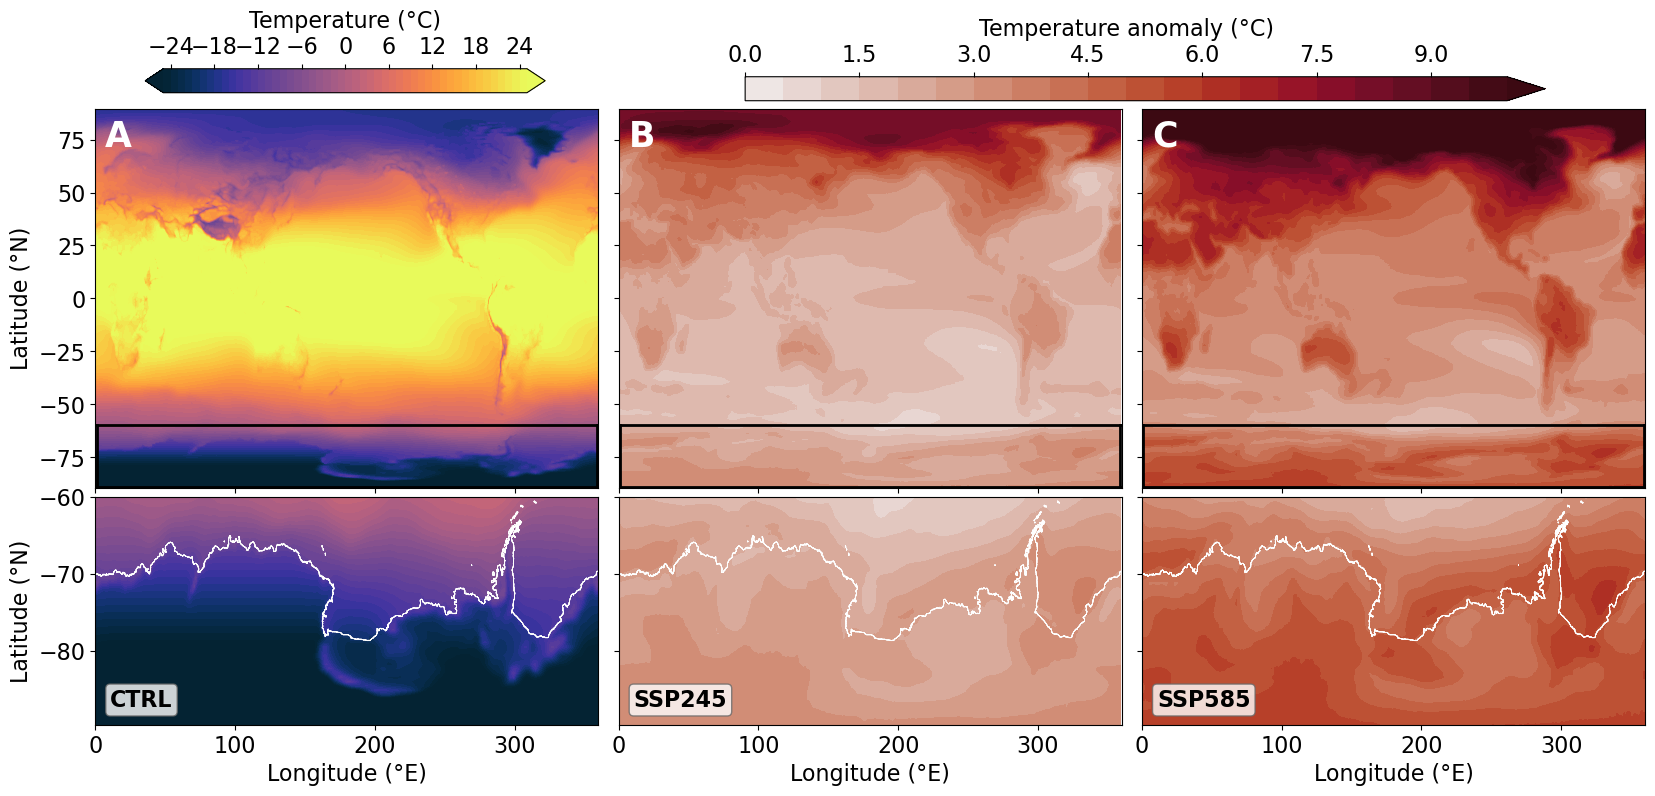

In [10]:
plt.rcParams.update({'font.size': 16})
expts_labels = ['CTRL','SSP245','SSP585']
vmin, vmax = 0, 10
levels = np.arange(-25, 26, 1)
levels_anom = np.arange(0, 10.5,0.5)

# Global
fig, axes = plt.subplots(2, 3, figsize=(20,8), sharex=True, gridspec_kw={'height_ratios': [2,1.2]})
plt.subplots_adjust(wspace=0.04, hspace=0.03)

cb_therm = axes[0,0].contourf(ctrl.longitude, ctrl.latitude, ctrl.tas_10m.mean('time'), 
                              cmap=cmo.thermal, levels=levels, extend='both')
axes[0,1].contourf(ctrl.longitude, ctrl.latitude, ssp245.tas_10m.mean('time') - ctrl.tas_10m.mean('time'), 
                     cmap=cmo.amp, levels=levels_anom, extend='max')
cb_anom = axes[0,2].contourf(ctrl.longitude, ctrl.latitude, ssp585.tas_10m.mean('time') - ctrl.tas_10m.mean('time'), 
                               cmap=cmo.amp, levels=levels_anom, extend='max')

for i, ax in enumerate(axes[0,:].flatten()):
    c = 'k'
    ax.plot([0,360], [-60, -60], c, lw=2)
    ax.plot([0,360], [-89.2, -89.2], c, lw=2)
    ax.plot([1,1], [-89.2, -60], c, lw=2)
    ax.plot([359,359], [-89.2, -60], c, lw=2)
axes[0,0].set_xlim([0,360])

# zoom in on Antarctica
axes[1,0].contourf(ctrl.longitude, ctrl.latitude, ctrl.tas_10m.mean('time'), 
                              cmap=cmo.thermal, levels=levels, extend='both')
axes[1,1].contourf(ctrl.longitude, ctrl.latitude, ssp245.tas_10m.mean('time')-ctrl.tas_10m.mean('time'), 
                   cmap=cmo.amp, levels=levels_anom, extend='max')
axes[1,2].contourf(ctrl.longitude, ctrl.latitude, ssp585.tas_10m.mean('time')-ctrl.tas_10m.mean('time'), 
                   cmap=cmo.amp, levels=levels_anom, extend='max')
axes[1,0].set_ylim([None,-60])
axes[1,1].set_ylim([None,-60])
axes[1,2].set_ylim([None,-60])
axes[1,1].yaxis.set_tick_params(labelbottom=False)
axes[1,2].yaxis.set_tick_params(labelleft=False)

axes[0,1].yaxis.set_tick_params(labelleft=False)
axes[0,2].yaxis.set_tick_params(labelleft=False)


for i, ax in enumerate(axes[1,:].flatten()):
    ax.set_xlabel(f'Longitude (\u00b0E)')
    ax.contour(lons, land_mask_lat,land_mask,colors='w',linewidths=0.5, zorder=2,)
    ax.text(0.03, 0.08, f'{expts_labels[i]}', fontsize=16, fontweight='bold', color='k', ha='left', transform=ax.transAxes,
                bbox=dict(facecolor='w', alpha=0.8, edgecolor='dimgrey', boxstyle='round,pad=0.2'))
axes[0,0].set_ylabel(f'Latitude (\u00b0N)')
axes[1,0].set_ylabel(f'Latitude (\u00b0N)')

#plt.colorbar(cb)
cbar = colorbar_horz(cb_therm, [0.15, 0.9, 0.2, 0.03], 'Temperature (\u00b0C)')
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar = colorbar_horz(cb_anom, [0.45, 0.89, 0.4, 0.03], 'Temperature anomaly (\u00b0C)')
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

labels = ['A','B','C','D','E','F']
for i, ax in enumerate(axes.flatten()):
    if i <3:
        ax.text(0.02, 0.9, f'{labels[i]}',  c='w', fontsize=25, fontweight='bold', transform=ax.transAxes)

# save to file
save_flag = 1
figfile = f'../figs/SuppFig_temp_anomalies.jpg'
if save_flag == 1:
    fig.savefig(figfile, bbox_inches='tight', dpi=300)
    
plt.show()

### Zonal wind

In [14]:
ctrl = xr.open_dataset(ctrl_dir + 'RYF.u_10.1990_1991.nc').load()
ssp245 = xr.open_dataset(ssp245_dir + 'RYF.u_10.1990_1991.nc').load() 
ssp585 = xr.open_dataset(ssp585_dir + 'RYF.u_10.1990_1991.nc').load()

In [15]:
div_line = xr.open_dataset('/g_e14/2022-GRL-easterlies/data/smooth_div_line.nc')['__xarray_dataarray_variable__']
div_line = div_line.rename('wind_div')
x = div_line[0].values
y = div_line[1].values
x[x<0] = x[x<0] + 360

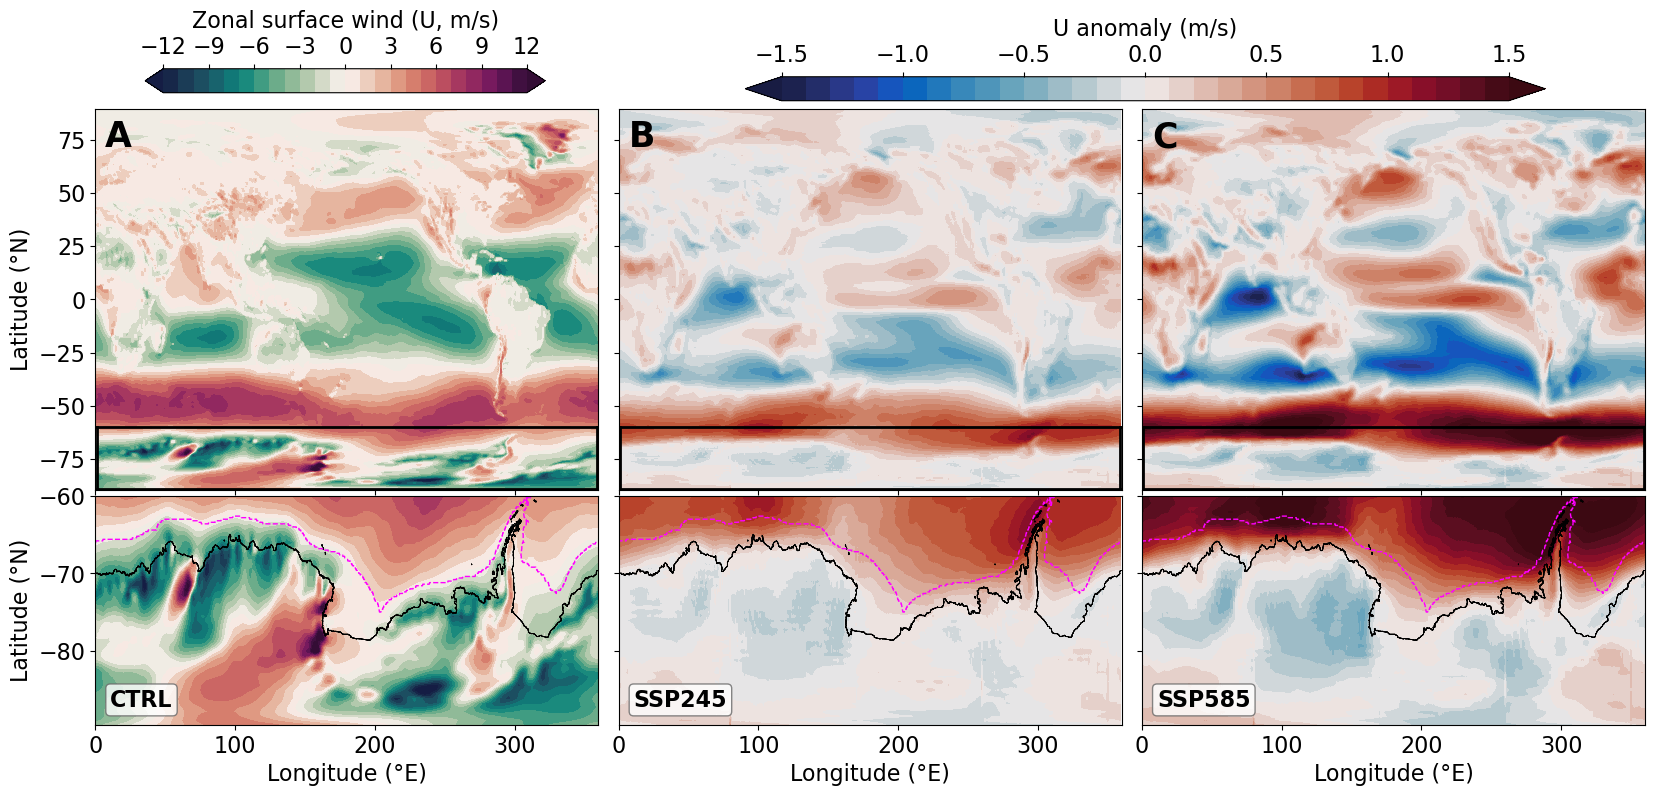

In [16]:
plt.rcParams.update({'font.size': 16})
levels = np.arange(-12, 13, 1)
levels_anom = np.arange(-1.5, 1.6, 0.1)

# Global
fig, axes = plt.subplots(2, 3, figsize=(20,8), sharex=True, gridspec_kw={'height_ratios': [2,1.2]})
plt.subplots_adjust(wspace=0.04, hspace=0.02)

cb_therm = axes[0,0].contourf(ctrl.longitude, ctrl.latitude, ctrl.uas_10m.mean('time'), 
                              cmap=cmo.curl, levels=levels, extend='both')
axes[0,1].contourf(ctrl.longitude, ctrl.latitude, ssp245.uas_10m.mean('time') - ctrl.uas_10m.mean('time'), 
                   levels=levels_anom, cmap=cmo.balance, extend='both')
cb_anom = axes[0,2].contourf(ctrl.longitude, ctrl.latitude, ssp585.uas_10m.mean('time') - ctrl.uas_10m.mean('time'), 
                            cmap=cmo.balance, levels=levels_anom, extend='both')

for i, ax in enumerate(axes[0,:].flatten()):
    c = 'k'
    ax.plot([0,360], [-60, -60], c, lw=2)
    ax.plot([0,360], [-89.2, -89.2], c, lw=2)
    ax.plot([1,1], [-89.2, -60], c, lw=2)
    ax.plot([359,359], [-89.2, -60], c, lw=2)
axes[0,0].set_xlim([0,360])

# zoom in on Antarctica
axes[1,0].contourf(ctrl.longitude, ctrl.latitude, ctrl.uas_10m.mean('time'), 
                   cmap=cmo.curl, levels=levels, extend='both')
axes[1,1].contourf(ctrl.longitude, ctrl.latitude, ssp245.uas_10m.mean('time') - ctrl.uas_10m.mean('time'), 
                   levels=levels_anom, cmap=cmo.balance, extend='both')
axes[1,2].contourf(ctrl.longitude, ctrl.latitude, ssp585.uas_10m.mean('time') - ctrl.uas_10m.mean('time'), 
                   cmap=cmo.balance, levels=levels_anom, extend='both')
axes[1,0].set_ylim([None,-60])
axes[1,1].set_ylim([None,-60])
axes[1,2].set_ylim([None,-60])
axes[1,1].yaxis.set_tick_params(labelbottom=False)
axes[1,2].yaxis.set_tick_params(labelleft=False)
axes[0,1].yaxis.set_tick_params(labelleft=False)
axes[0,2].yaxis.set_tick_params(labelleft=False)


for i, ax in enumerate(axes[1,:].flatten()):
    ax.set_xlabel(f'Longitude (\u00b0E)')
    ax.contour(lons, land_mask_lat,land_mask,colors='k',linewidths=0.5, zorder=2,)
    ax.text(0.03, 0.08, f'{expts_labels[i]}', fontsize=16, fontweight='bold', color='k', ha='left', transform=ax.transAxes,
                bbox=dict(facecolor='w', alpha=0.8, edgecolor='dimgrey', boxstyle='round,pad=0.2'))
    ax.plot(x[:1044], y[:1044], 'fuchsia', linewidth=1, ls='--', zorder=2)
    ax.plot(x[1044:], y[1044:], 'fuchsia', linewidth=1, ls='--', zorder=2)
    
axes[0,0].set_ylabel(f'Latitude (\u00b0N)')
axes[1,0].set_ylabel(f'Latitude (\u00b0N)')

#plt.colorbar(cb)
cbar = colorbar_horz(cb_therm, [0.15, 0.9, 0.2, 0.03], 'Zonal surface wind (U, m/s)')
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar = colorbar_horz(cb_anom, [0.45, 0.89, 0.4, 0.03], 'U anomaly (m/s)')
cbar.ax.set_xticks(np.arange(-1.5, 1.6, 0.5))
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

labels = ['A','B','C','D','E','F']
for i, ax in enumerate(axes.flatten()):
    if i <3:
        ax.text(0.02, 0.9, f'{labels[i]}',  c='k', fontsize=25, fontweight='bold', transform=ax.transAxes)

# save to file
save_flag = 1
figfile = f'../figs/SuppFig_wind_zonal_anomalies.jpg'
if save_flag == 1:
    fig.savefig(figfile, bbox_inches='tight', dpi=300)

plt.show()

### Meridional wind

In [9]:
ctrl = xr.open_dataset(ctrl_dir + 'RYF.v_10.1990_1991.nc').load()
ssp245 = xr.open_dataset(ssp245_dir + 'RYF.v_10.1990_1991.nc').load() 
ssp585 = xr.open_dataset(ssp585_dir + 'RYF.v_10.1990_1991.nc').load()

In [10]:
div_line = xr.open_dataset('/g_e14/2022-GRL-easterlies/data/smooth_div_line.nc')['__xarray_dataarray_variable__']
div_line = div_line.rename('wind_div')
x = div_line[0].values
y = div_line[1].values
x[x<0] = x[x<0] + 360

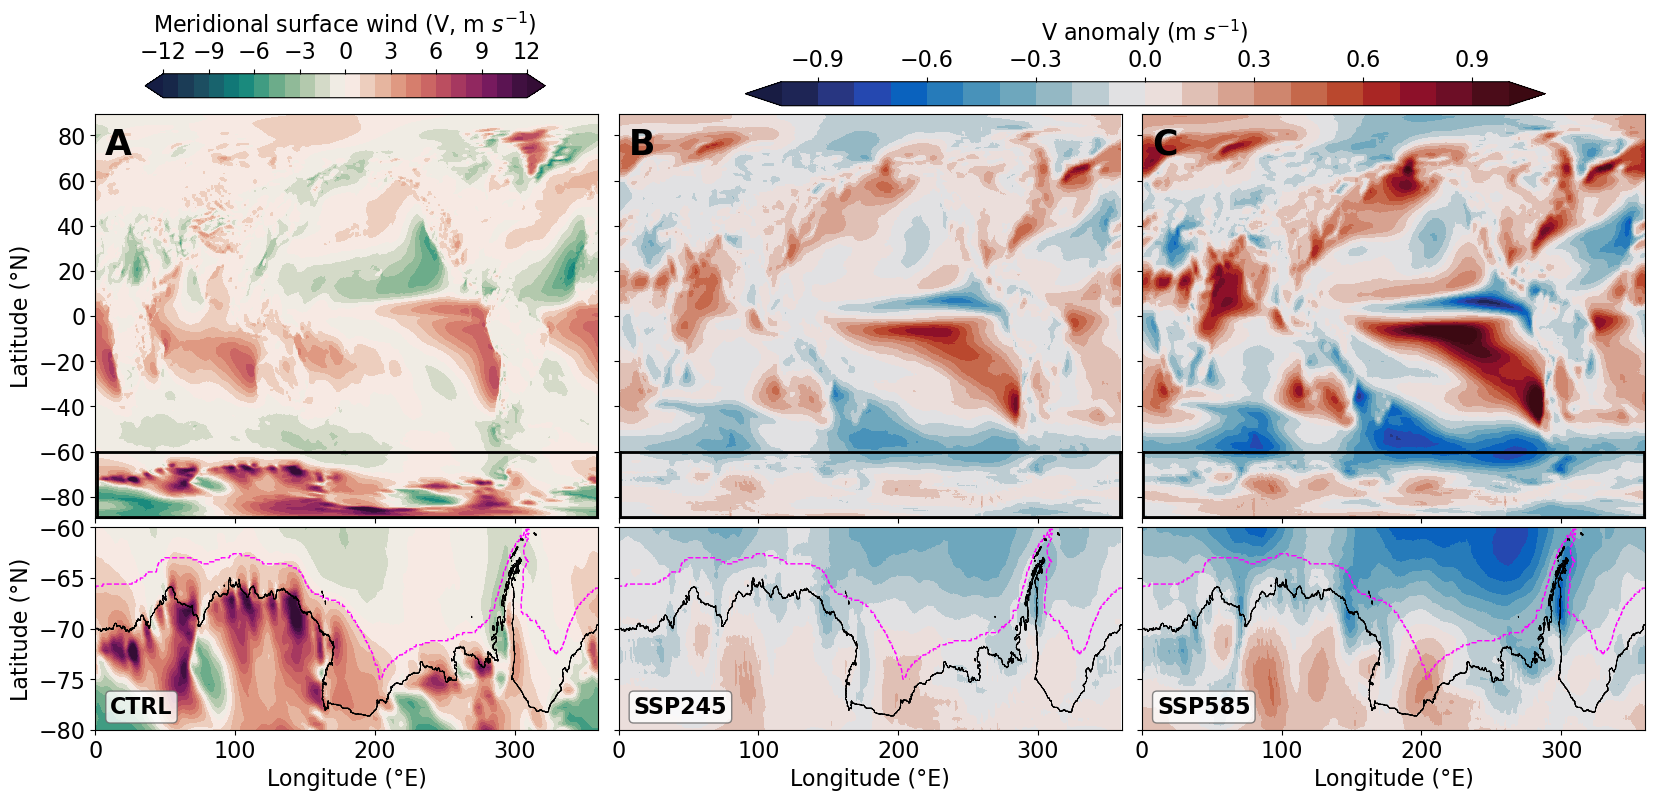

In [14]:
plt.rcParams.update({'font.size': 16})
expts_labels = ['CTRL','SSP245','SSP585']
levels = np.arange(-12, 13, 1)
levels_anom = np.arange(-1.0, 1.1, 0.1)

# Global
fig, axes = plt.subplots(2, 3, figsize=(20,8), sharex=True, gridspec_kw={'height_ratios': [2,1.0]})
plt.subplots_adjust(wspace=0.04, hspace=0.03)

cb_therm = axes[0,0].contourf(ctrl.longitude, ctrl.latitude, ctrl.vas_10m.mean('time'), 
                              cmap=cmo.curl, levels=levels, extend='both')
axes[0,1].contourf(ctrl.longitude, ctrl.latitude, ssp245.vas_10m.mean('time') - ctrl.vas_10m.mean('time'), 
                   cmap=cmo.balance, levels=levels_anom, extend='both')
cb_anom = axes[0,2].contourf(ctrl.longitude, ctrl.latitude, ssp585.vas_10m.mean('time') - ctrl.vas_10m.mean('time'), 
                             cmap=cmo.balance, levels=levels_anom, extend='both')

for i, ax in enumerate(axes[0,:].flatten()):
    c = 'k'
    ax.plot([0,360], [-60, -60], c, lw=2)
    ax.plot([0,360], [-89.2, -89.2], c, lw=2)
    ax.plot([1,1], [-89.2, -60], c, lw=2)
    ax.plot([359,359], [-89.2, -60], c, lw=2)
axes[0,0].set_xlim([0,360])

# zoom in on Antarctica
axes[1,0].contourf(ctrl.longitude, ctrl.latitude, ctrl.vas_10m.mean('time'), 
                   cmap=cmo.curl, levels=levels, extend='both')
axes[1,1].contourf(ctrl.longitude, ctrl.latitude, ssp245.vas_10m.mean('time') - ctrl.vas_10m.mean('time'), 
                   cmap=cmo.balance, levels=levels_anom, extend='both')
axes[1,2].contourf(ctrl.longitude, ctrl.latitude, ssp585.vas_10m.mean('time') - ctrl.vas_10m.mean('time'), 
                   cmap=cmo.balance, levels=levels_anom, extend='both')
axes[1,0].set_ylim([-80,-60])
axes[1,1].set_ylim([-80,-60])
axes[1,2].set_ylim([-80,-60])
axes[1,1].yaxis.set_tick_params(labelbottom=False)
axes[1,2].yaxis.set_tick_params(labelleft=False)
axes[0,1].yaxis.set_tick_params(labelleft=False)
axes[0,2].yaxis.set_tick_params(labelleft=False)

for i, ax in enumerate(axes[1,:].flatten()):
    ax.set_xlabel(f'Longitude (\u00b0E)')
    ax.contour(lons, land_mask_lat,land_mask,colors='k',linewidths=0.5, zorder=2,)
    #ax.contourf(ht.xt_ocean,land_mask_lat,land_mask_masked,colors='w',alpha=0.4,zorder=2,)
    ax.text(0.03, 0.08, f'{expts_labels[i]}', fontsize=16, fontweight='bold', color='k', ha='left', transform=ax.transAxes,
                bbox=dict(facecolor='w', alpha=0.8, edgecolor='dimgrey', boxstyle='round,pad=0.2'))
    ax.plot(x[:1044], y[:1044], 'fuchsia', linewidth=1, ls='--', zorder=2)
    ax.plot(x[1044:], y[1044:], 'fuchsia', linewidth=1, ls='--', zorder=2)

axes[0,0].set_ylabel(f'Latitude (\u00b0N)')
axes[1,0].set_ylabel(f'Latitude (\u00b0N)')
#plt.colorbar(cb)
cbar = colorbar_horz(cb_therm, [0.15, 0.9, 0.2, 0.03], 'Meridional surface wind (V, m $s^{-1}$)')
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar = colorbar_horz(cb_anom, [0.45, 0.89, 0.4, 0.03], 'V anomaly (m $s^{-1}$)')
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

labels = ['A','B','C','D','E','F']
for i, ax in enumerate(axes.flatten()):
    if i <3:
        ax.text(0.02, 0.9, f'{labels[i]}',  c='k', fontsize=25, fontweight='bold', transform=ax.transAxes)
        

# save to file
save_flag = 1
figfile = f'../figs/SuppFig_wind_meridional_anomalies.jpg'
if save_flag == 1:
    fig.savefig(figfile, bbox_inches='tight', dpi=300)
    
plt.show()

### Liquid precipitation (Rainfall)

In [57]:
ctrl = xr.open_dataset(ctrl_dir + 'RYF.rain.1990_1991.nc').load()
ssp245 = xr.open_dataset(ssp245_dir + 'RYF.rain.1990_1991.nc').load() 
ssp585 = xr.open_dataset(ssp585_dir + 'RYF.rain.1990_1991.nc').load()

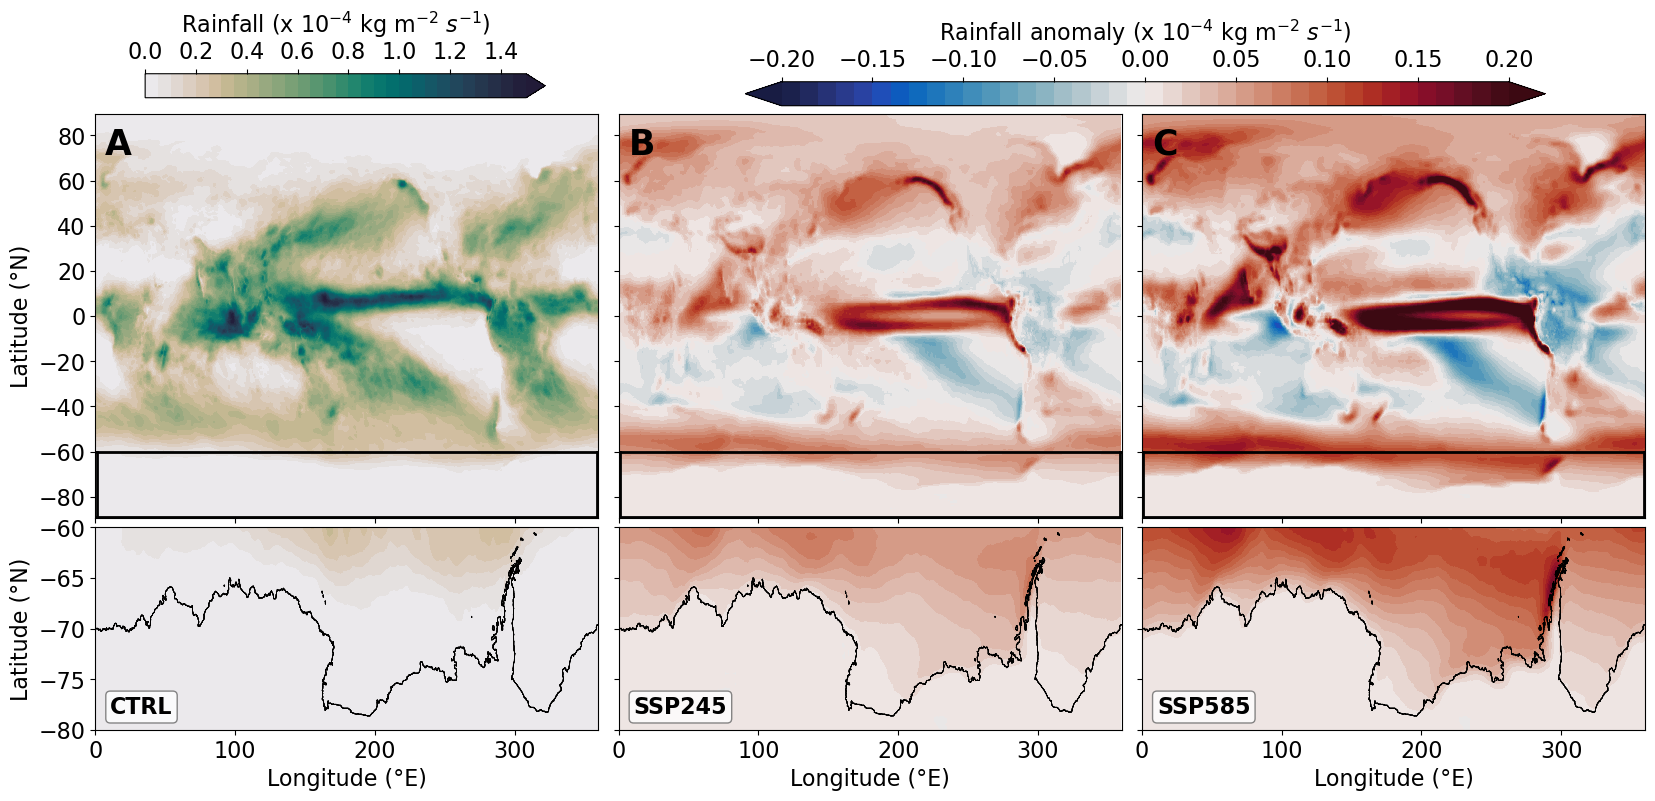

In [58]:
plt.rcParams.update({'font.size': 16})
levels = np.arange(0, 1.55, 0.05)
levels_anom = np.arange(-0.2, 0.21, 0.01)

# Global
fig, axes = plt.subplots(2, 3, figsize=(20,8), sharex=True, gridspec_kw={'height_ratios': [2,1.0]})
plt.subplots_adjust(wspace=0.04, hspace=0.03)

cb_therm = axes[0,0].contourf(ctrl.longitude, ctrl.latitude, ctrl.prrn.mean('time')*10000, 
                              cmap=cmo.rain, levels=levels, extend='max')
axes[0,1].contourf(ctrl.longitude, ctrl.latitude, (ssp245.prrn.mean('time') - ctrl.prrn.mean('time'))*10000, 
                   cmap=cmo.balance, levels=levels_anom, extend='both')
cb_anom = axes[0,2].contourf(ctrl.longitude, ctrl.latitude, (ssp585.prrn.mean('time') - ctrl.prrn.mean('time'))*10000, 
                             cmap=cmo.balance, levels=levels_anom, extend='both')

for i, ax in enumerate(axes[0,:].flatten()):
    c = 'k'
    ax.plot([0,360], [-60, -60], c, lw=2)
    ax.plot([0,360], [-89.2, -89.2], c, lw=2)
    ax.plot([1,1], [-89.2, -60], c, lw=2)
    ax.plot([359,359], [-89.2, -60], c, lw=2)
axes[0,0].set_xlim([0,360])

# zoom in on Antarctica
axes[1,0].contourf(ctrl.longitude, ctrl.latitude, ctrl.prrn.mean('time')*10000, 
                   cmap=cmo.rain, levels=levels, extend='max')
axes[1,1].contourf(ctrl.longitude, ctrl.latitude, (ssp245.prrn.mean('time') - ctrl.prrn.mean('time'))*10000, 
                   cmap=cmo.balance, levels=levels_anom, extend='both')
axes[1,2].contourf(ctrl.longitude, ctrl.latitude, (ssp585.prrn.mean('time') - ctrl.prrn.mean('time'))*10000, 
                   cmap=cmo.balance, levels=levels_anom, extend='both')
axes[1,0].set_ylim([-80,-60])
axes[1,1].set_ylim([-80,-60])
axes[1,2].set_ylim([-80,-60])
axes[1,1].yaxis.set_tick_params(labelbottom=False)
axes[1,2].yaxis.set_tick_params(labelleft=False)
axes[0,1].yaxis.set_tick_params(labelleft=False)
axes[0,2].yaxis.set_tick_params(labelleft=False)

for i, ax in enumerate(axes[1,:].flatten()):
    ax.set_xlabel(f'Longitude (\u00b0E)')
    ax.contour(lons, land_mask_lat,land_mask,colors='k',linewidths=0.5, zorder=2,)
    ax.text(0.03, 0.08, f'{expts_labels[i]}', fontsize=16, fontweight='bold', color='k', ha='left', transform=ax.transAxes,
                bbox=dict(facecolor='w', alpha=0.8, edgecolor='dimgrey', boxstyle='round,pad=0.2'))

axes[0,0].set_ylabel(f'Latitude (\u00b0N)')
axes[1,0].set_ylabel(f'Latitude (\u00b0N)')
#plt.colorbar(cb)
cbar = colorbar_horz(cb_therm, [0.15, 0.9, 0.2, 0.03], 'Rainfall (x 10$^{-4}$ kg m$^{-2}$ $s^{-1}$)')
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar = colorbar_horz(cb_anom, [0.45, 0.89, 0.4, 0.03], 'Rainfall anomaly (x 10$^{-4}$ kg m$^{-2}$ $s^{-1}$)')
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

labels = ['A','B','C','D','E','F']
for i, ax in enumerate(axes.flatten()):
    if i <3:
        ax.text(0.02, 0.9, f'{labels[i]}',  c='k', fontsize=25, fontweight='bold', transform=ax.transAxes)
        
# save to file
save_flag = 1
figfile = f'../figs/SuppFig_precip-liquid_anomalies.jpg'
if save_flag == 1:
    fig.savefig(figfile, bbox_inches='tight', dpi=300)
    
plt.show()

### Frozen precipitation (snowfall)

In [59]:
ctrl = xr.open_dataset(ctrl_dir + 'RYF.snow.1990_1991.nc').load()
ssp245 = xr.open_dataset(ssp245_dir + 'RYF.snow.1990_1991.nc').load() 
ssp585 = xr.open_dataset(ssp585_dir + 'RYF.snow.1990_1991.nc').load()

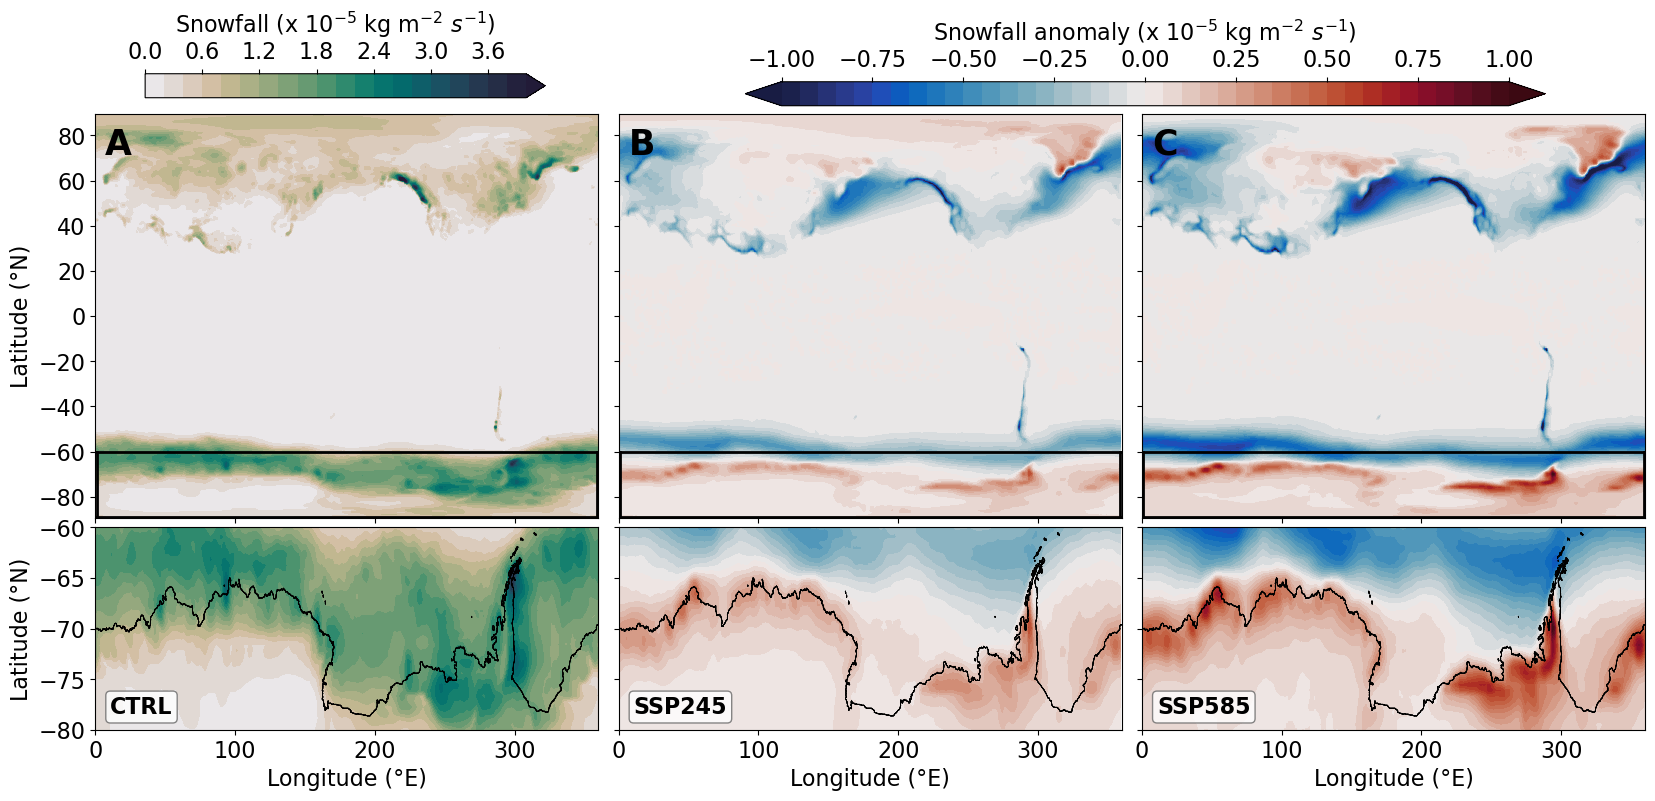

In [62]:
plt.rcParams.update({'font.size': 16})
levels = np.arange(0, 4.2, 0.2)
levels_anom = np.arange(-1, 1.05, 0.05)

# Global
fig, axes = plt.subplots(2, 3, figsize=(20,8), sharex=True, gridspec_kw={'height_ratios': [2,1.0]})
plt.subplots_adjust(wspace=0.04, hspace=0.03)

cb_therm = axes[0,0].contourf(ctrl.longitude, ctrl.latitude, ctrl.prsn.mean('time')*100000, 
                              cmap=cmo.rain, levels=levels, extend='max')
axes[0,1].contourf(ctrl.longitude, ctrl.latitude, (ssp245.prsn.mean('time') - ctrl.prsn.mean('time'))*100000, 
                   cmap=cmo.balance, levels=levels_anom, extend='both')
cb_anom = axes[0,2].contourf(ctrl.longitude, ctrl.latitude, (ssp585.prsn.mean('time') - ctrl.prsn.mean('time'))*100000, 
                             cmap=cmo.balance, levels=levels_anom, extend='both')

for i, ax in enumerate(axes[0,:].flatten()):
    c = 'k'
    ax.plot([0,360], [-60, -60], c, lw=2)
    ax.plot([0,360], [-89.2, -89.2], c, lw=2)
    ax.plot([1,1], [-89.2, -60], c, lw=2)
    ax.plot([359,359], [-89.2, -60], c, lw=2)
axes[0,0].set_xlim([0,360])

# zoom in on Antarctica
axes[1,0].contourf(ctrl.longitude, ctrl.latitude, ctrl.prsn.mean('time')*100000, 
                   cmap=cmo.rain, levels=levels, extend='max')
axes[1,1].contourf(ctrl.longitude, ctrl.latitude, (ssp245.prsn.mean('time') - ctrl.prsn.mean('time'))*100000, 
                   cmap=cmo.balance, levels=levels_anom, extend='both')
axes[1,2].contourf(ctrl.longitude, ctrl.latitude, (ssp585.prsn.mean('time') - ctrl.prsn.mean('time'))*100000, 
                   cmap=cmo.balance, levels=levels_anom, extend='both')
axes[1,0].set_ylim([-80,-60])
axes[1,1].set_ylim([-80,-60])
axes[1,2].set_ylim([-80,-60])
axes[1,1].yaxis.set_tick_params(labelbottom=False)
axes[1,2].yaxis.set_tick_params(labelleft=False)
axes[0,1].yaxis.set_tick_params(labelleft=False)
axes[0,2].yaxis.set_tick_params(labelleft=False)

for i, ax in enumerate(axes[1,:].flatten()):
    ax.set_xlabel(f'Longitude (\u00b0E)')
    ax.contour(lons, land_mask_lat,land_mask,colors='k',linewidths=0.5, zorder=2,)
    ax.text(0.03, 0.08, f'{expts_labels[i]}', fontsize=16, fontweight='bold', color='k', ha='left', transform=ax.transAxes,
                bbox=dict(facecolor='w', alpha=0.8, edgecolor='dimgrey', boxstyle='round,pad=0.2'))

axes[0,0].set_ylabel(f'Latitude (\u00b0N)')
axes[1,0].set_ylabel(f'Latitude (\u00b0N)')
#plt.colorbar(cb)
cbar = colorbar_horz(cb_therm, [0.15, 0.9, 0.2, 0.03], 'Snowfall (x 10$^{-5}$ kg m$^{-2}$ $s^{-1}$)')
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar = colorbar_horz(cb_anom, [0.45, 0.89, 0.4, 0.03], 'Snowfall anomaly (x 10$^{-5}$ kg m$^{-2}$ $s^{-1}$)')
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

labels = ['A','B','C','D','E','F']
for i, ax in enumerate(axes.flatten()):
    if i <3:
        ax.text(0.02, 0.9, f'{labels[i]}',  c='k', fontsize=25, fontweight='bold', transform=ax.transAxes)
        
# save to file
save_flag = 1
figfile = f'../figs/SuppFig_precip-solid_anomalies.jpg'
if save_flag == 1:
    fig.savefig(figfile, bbox_inches='tight', dpi=300)
    
plt.show()

### Longwave downwelling radiation

In [63]:
ctrl = xr.open_dataset(ctrl_dir + 'RYF.rlds.1990_1991.nc').load()
ssp245 = xr.open_dataset(ssp245_dir + 'RYF.rlds.1990_1991.nc').load() 
ssp585 = xr.open_dataset(ssp585_dir + 'RYF.rlds.1990_1991.nc').load()

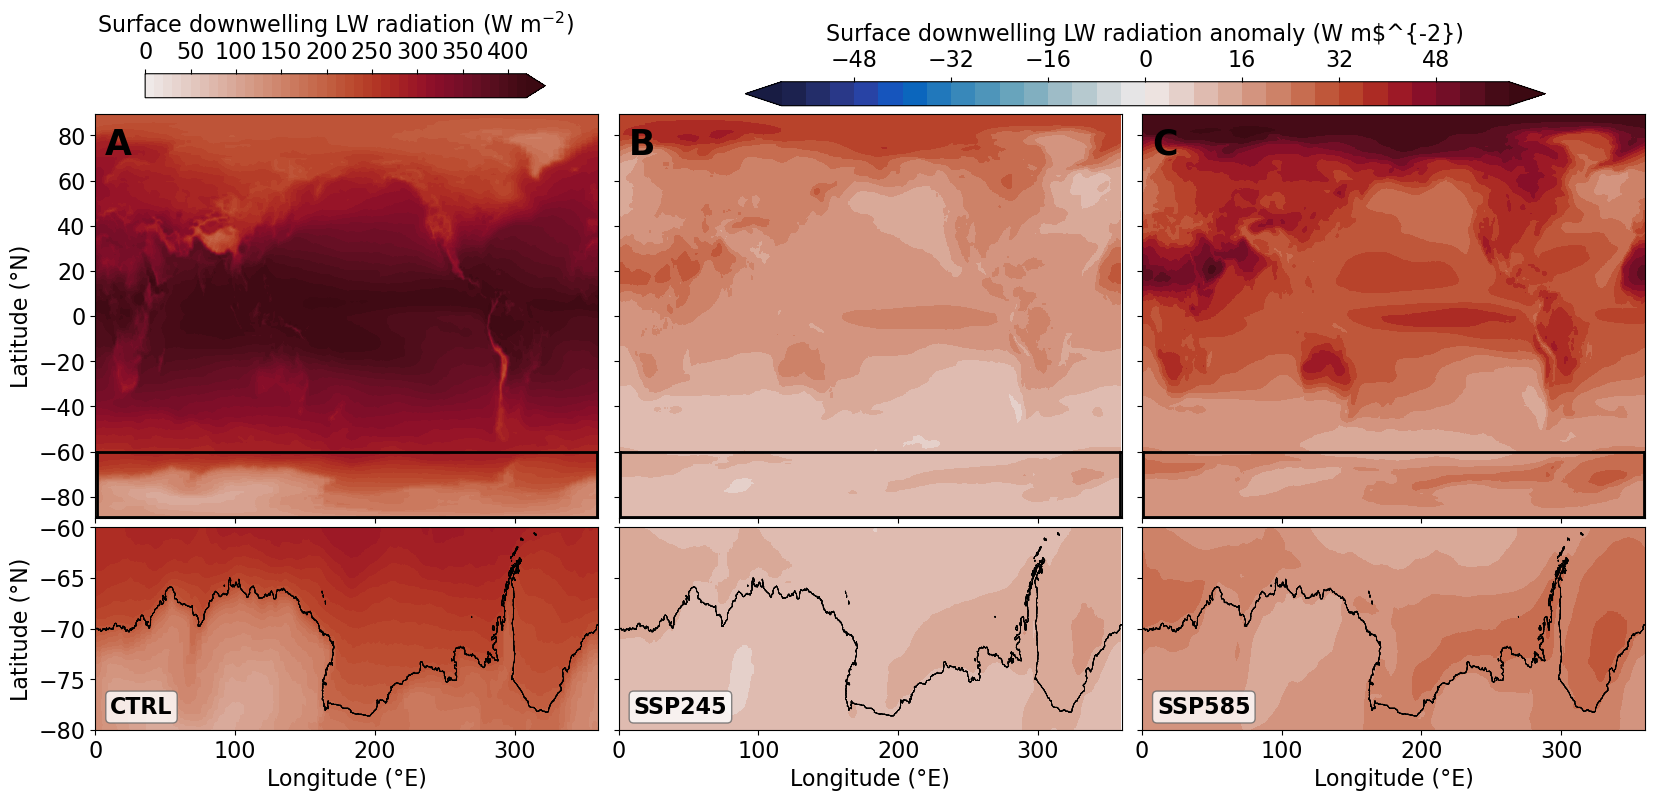

In [70]:
plt.rcParams.update({'font.size': 16})
levels = np.arange(0, 430, 10)
levels_anom = np.arange(-60, 64, 4)

# Global
fig, axes = plt.subplots(2, 3, figsize=(20,8), sharex=True, gridspec_kw={'height_ratios': [2,1.0]})
plt.subplots_adjust(wspace=0.04, hspace=0.03)

cb_therm = axes[0,0].contourf(ctrl.longitude, ctrl.latitude, ctrl.rlds.mean('time'), 
                              cmap=cmo.amp, levels=levels, extend='max')
axes[0,1].contourf(ctrl.longitude, ctrl.latitude, (ssp245.rlds.mean('time') - ctrl.rlds.mean('time')), 
                   cmap=cmo.balance, levels=levels_anom, extend='both')
cb_anom = axes[0,2].contourf(ctrl.longitude, ctrl.latitude, (ssp585.rlds.mean('time') - ctrl.rlds.mean('time')), 
                             cmap=cmo.balance, levels=levels_anom, extend='both')

for i, ax in enumerate(axes[0,:].flatten()):
    c = 'k'
    ax.plot([0,360], [-60, -60], c, lw=2)
    ax.plot([0,360], [-89.2, -89.2], c, lw=2)
    ax.plot([1,1], [-89.2, -60], c, lw=2)
    ax.plot([359,359], [-89.2, -60], c, lw=2)
axes[0,0].set_xlim([0,360])

# zoom in on Antarctica
axes[1,0].contourf(ctrl.longitude, ctrl.latitude, ctrl.rlds.mean('time'), 
                   cmap=cmo.amp, levels=levels, extend='max')
axes[1,1].contourf(ctrl.longitude, ctrl.latitude, (ssp245.rlds.mean('time') - ctrl.rlds.mean('time')), 
                   cmap=cmo.balance, levels=levels_anom, extend='both')
axes[1,2].contourf(ctrl.longitude, ctrl.latitude, (ssp585.rlds.mean('time') - ctrl.rlds.mean('time')), 
                   cmap=cmo.balance, levels=levels_anom, extend='both')
axes[1,0].set_ylim([-80,-60])
axes[1,1].set_ylim([-80,-60])
axes[1,2].set_ylim([-80,-60])
axes[1,1].yaxis.set_tick_params(labelbottom=False)
axes[1,2].yaxis.set_tick_params(labelleft=False)
axes[0,1].yaxis.set_tick_params(labelleft=False)
axes[0,2].yaxis.set_tick_params(labelleft=False)

for i, ax in enumerate(axes[1,:].flatten()):
    ax.set_xlabel(f'Longitude (\u00b0E)')
    ax.contour(lons, land_mask_lat,land_mask,colors='k',linewidths=0.5, zorder=2,)
    #ax.contourf(ht.xt_ocean,land_mask_lat,land_mask_masked,colors='w',alpha=0.4,zorder=2,)
    ax.text(0.03, 0.08, f'{expts_labels[i]}', fontsize=16, fontweight='bold', color='k', ha='left', transform=ax.transAxes,
                bbox=dict(facecolor='w', alpha=0.8, edgecolor='dimgrey', boxstyle='round,pad=0.2'))
    #ax.plot(x[:1044], y[:1044], 'fuchsia', linewidth=1, ls='--', zorder=2)
    #ax.plot(x[1044:], y[1044:], 'fuchsia', linewidth=1, ls='--', zorder=2)

axes[0,0].set_ylabel(f'Latitude (\u00b0N)')
axes[1,0].set_ylabel(f'Latitude (\u00b0N)')
#plt.colorbar(cb)
cbar = colorbar_horz(cb_therm, [0.15, 0.9, 0.2, 0.03], 'Surface downwelling LW radiation (W m$^{-2}$)')
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar = colorbar_horz(cb_anom, [0.45, 0.89, 0.4, 0.03], 'Surface downwelling LW radiation anomaly (W m$^{-2})')
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

labels = ['A','B','C','D','E','F']
for i, ax in enumerate(axes.flatten()):
    if i <3:
        ax.text(0.02, 0.9, f'{labels[i]}',  c='k', fontsize=25, fontweight='bold', transform=ax.transAxes)
        
# save to file
save_flag = 1
figfile = f'../figs/SuppFig_longwave-downwelling-radiation_anomalies.jpg'
if save_flag == 1:
    fig.savefig(figfile, bbox_inches='tight', dpi=300)
    
plt.show()